In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)

using device: cpu


In [5]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = '/HACKATHON'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/HACKATHON


In [ ]:
%pwd

'/content/gdrive/My Drive/HACKATHON'

In [3]:
df_train = pd.read_csv('processed_waiting_times_train.csv')

In [4]:
out_features = max(df_train["WAIT_TIME_IN_2H"]) + 1
print(out_features)

y = df_train["WAIT_TIME_IN_2H"]
print(y)

x = df_train
x.drop(["WAIT_TIME_IN_2H"], axis=1, inplace=True)
print(x)

in_features = len(x.columns)
print(in_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

x_train = torch.tensor(x_train.values, dtype=torch.float64, device=device)
x_test = torch.tensor(x_test.values, dtype=torch.float64, device=device)
y_train = torch.tensor(y_train.values, dtype=torch.int64, device=device)
y_test = torch.tensor(y_test.values, dtype=torch.int64, device=device)

32
0        6
1        5
2        7
3        2
4        2
        ..
37013    2
37014    4
37015    2
37016    9
37017    4
Name: WAIT_TIME_IN_2H, Length: 37018, dtype: int64
       ADJUST_CAPACITY  DOWNTIME  CURRENT_WAIT_TIME  TIME_TO_PARADE_1  \
0            -0.660639 -0.168584          -0.240147         -1.152579   
1            -0.660639 -0.168584           0.468341          1.280950   
2            -0.527907 -0.168584           0.822585         -1.152579   
3            -0.726608 -0.168584          -0.594390         -0.170629   
4            -1.033079 -0.168584          -0.594390         -1.152579   
...                ...       ...                ...               ...   
37013         1.356085 -0.168584           0.468341          0.555161   
37014        -0.527907 -0.168584          -0.594390          0.939402   
37015         1.356085 -0.168584          -0.594390         -0.256016   
37016         1.356085 -0.168584           0.468341          0.896709   
37017        -1.033079

In [5]:
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [6]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

utils

In [7]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            y_res = model(x)
            predictions = F.softmax(y_res, dim=1)
            argmax_indices = torch.argmax(predictions, dim=1)

            num_correct += torch.sum(torch.eq(argmax_indices, y))
            num_samples += int(y_res.size()[0])

        acc = float(num_correct) / num_samples
        #print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        return acc

def check_rmse(x_test, y_test, model):
    model.eval()
    x_test = x_test.to(device=device, dtype=torch.float)
    y_hat = torch.argmax(model(x_test), dim=1)
    rmse = torch.sqrt(torch.sum((y_hat * 5 - y_test * 5)**2) / len(y_hat))
    return float(rmse)

def check_rmse_numeric(x_test, y_test, model):
    model.eval()
    x_test = x_test.to(device=device, dtype=torch.float)
    y_hat = model(x_test)
    rmse = torch.sqrt(torch.sum((y_hat * 5 - y_test * 5)**2) / len(y_hat))
    return float(rmse)

In [8]:
def train_module(model, optimizer, x_train, y_train, rmse_function, epochs=1, batch_size=64, rmse_on_test = False, x_test=None, y_test=None):
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    losses = []
    rmses = []
    rmses_test = []

    model = model.to(device=device)
    model.train()
    for e in range(epochs):
        for inputs, targets in train_loader:
            inputs = inputs.to(device=device, dtype=torch.float)
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        losses.append(loss.item())
        current_rmse      = rmse_function(x_train, y_train, model)
        current_rmse_test = rmse_function(x_test, y_test, model)

        rmses.append(current_rmse)
        rmses_test.append(current_rmse_test)

        print(f'Epoch [{e+1}/{epochs}] -  Loss: {loss.item():.4f} - Rmse: {current_rmse:.4f}')
        if(rmse_on_test): print(f'\t \t \t  test rmse: {current_rmse_test:.4f}')

    return losses, rmses, rmses_test

training

In [98]:
class Swish(nn.Module):
  def forward(self, x):
    return x*torch.sigmoid(x)

In [21]:
model = nn.Sequential(
    nn.Linear(in_features, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(32, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(32, out_features),
)
model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr=8e-2, momentum=0.90, nesterov = True)
criterion = nn.CrossEntropyLoss()

num_epochs = 100

losses, rmses, rmses_test = train_module(model, optimizer, x_train, y_train, check_rmse ,num_epochs, 128, True, x_test, y_test)

Epoch [1/100] -  Loss: 2.1487 - Rmse: 11.0262
	 	 	  test rmse: 11.1941
Epoch [2/100] -  Loss: 2.1995 - Rmse: 10.2701
	 	 	  test rmse: 10.5168
Epoch [3/100] -  Loss: 1.7948 - Rmse: 9.9709
	 	 	  test rmse: 10.2483
Epoch [4/100] -  Loss: 1.9183 - Rmse: 9.8253
	 	 	  test rmse: 10.0660
Epoch [5/100] -  Loss: 1.6708 - Rmse: 10.3226
	 	 	  test rmse: 10.5843
Epoch [6/100] -  Loss: 1.8228 - Rmse: 10.4895
	 	 	  test rmse: 10.7094
Epoch [7/100] -  Loss: 1.7665 - Rmse: 9.6847
	 	 	  test rmse: 10.0650
Epoch [8/100] -  Loss: 1.5443 - Rmse: 9.2763
	 	 	  test rmse: 9.7001
Epoch [9/100] -  Loss: 1.4328 - Rmse: 9.6526
	 	 	  test rmse: 10.0522
Epoch [10/100] -  Loss: 1.3044 - Rmse: 9.6684
	 	 	  test rmse: 10.0638
Epoch [11/100] -  Loss: 1.6606 - Rmse: 9.5258
	 	 	  test rmse: 9.9730
Epoch [12/100] -  Loss: 1.5653 - Rmse: 9.4497
	 	 	  test rmse: 9.8734
Epoch [13/100] -  Loss: 1.6381 - Rmse: 9.5132
	 	 	  test rmse: 10.0263
Epoch [14/100] -  Loss: 1.4074 - Rmse: 9.3494
	 	 	  test rmse: 9.9307
E

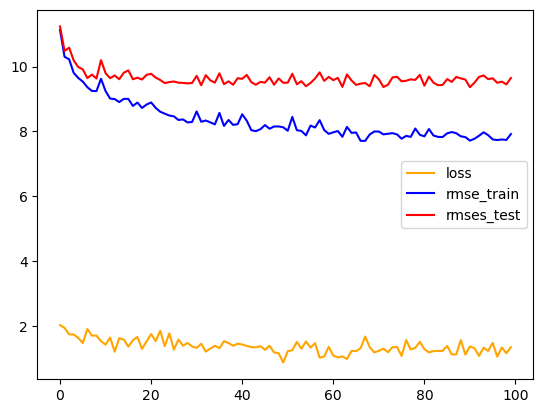

In [16]:
plt.plot(losses, color="orange")
plt.plot(rmses, color="blue")
plt.plot(rmses_test, color="red")
plt.legend(["loss", "rmse_train", "rmses_test"])

In [11]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

print(check_accuracy(train_loader, model))
print(check_accuracy(test_loader, model))

0.880867157425542
0.5086439762290653


accuracy vs lr

Epoch [1/5] -  Loss: 3.4709 - Rmse: 82.5171
	 	 	  test rmse: 83.2219
Epoch [2/5] -  Loss: 3.5032 - Rmse: 80.4270
	 	 	  test rmse: 80.9883
Epoch [3/5] -  Loss: 3.4751 - Rmse: 78.2548
	 	 	  test rmse: 78.4266
Epoch [4/5] -  Loss: 3.3968 - Rmse: 75.8028
	 	 	  test rmse: 75.7078
Epoch [5/5] -  Loss: 3.3211 - Rmse: 73.2134
	 	 	  test rmse: 72.9911
lr 1e-05 / rmse 72.99108123779297
Epoch [1/5] -  Loss: 3.6458 - Rmse: 69.7326
	 	 	  test rmse: 70.2717
Epoch [2/5] -  Loss: 3.3199 - Rmse: 55.9890
	 	 	  test rmse: 56.9167
Epoch [3/5] -  Loss: 3.2011 - Rmse: 30.5287
	 	 	  test rmse: 30.7865
Epoch [4/5] -  Loss: 2.9331 - Rmse: 17.6470
	 	 	  test rmse: 17.4804
Epoch [5/5] -  Loss: 2.6198 - Rmse: 15.7544
	 	 	  test rmse: 15.7447
lr 0.0001 / rmse 15.744726181030273
Epoch [1/5] -  Loss: 2.7499 - Rmse: 15.7777
	 	 	  test rmse: 15.7831
Epoch [2/5] -  Loss: 2.2366 - Rmse: 13.2851
	 	 	  test rmse: 13.1777
Epoch [3/5] -  Loss: 2.2461 - Rmse: 12.6135
	 	 	  test rmse: 12.5095
Epoch [4/5] -  Loss:

/var/folders/n9/pd4m7bps7_b_427s0yfq1m600000gn/T/ipykernel_46808/3552250896.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


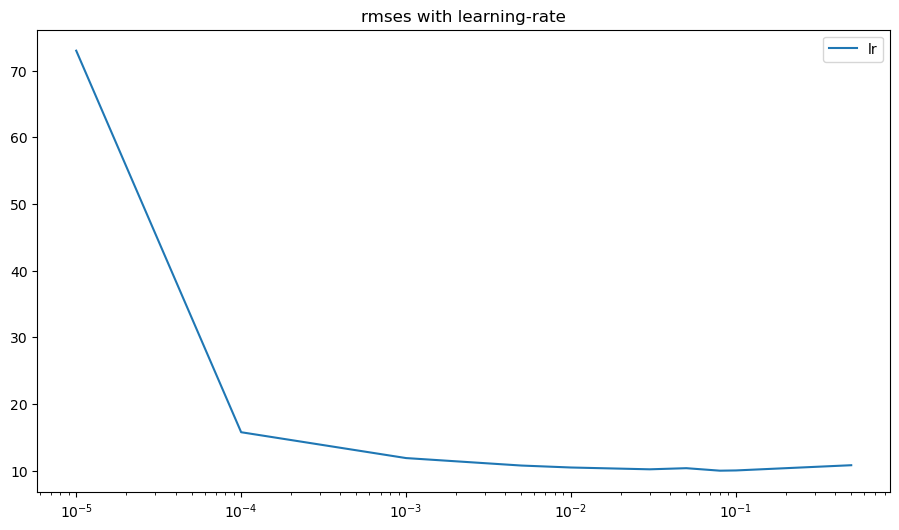

In [17]:
lrs = [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 8e-2, 1e-1, 5e-1]
rmses = []

for lr in lrs:
  model = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_features),
  )
  optimizer = optim.SGD(model.parameters(), momentum=0.8, lr=lr, nesterov=True)
  criterion = nn.CrossEntropyLoss()
  _, _, rmses_test = train_module(model, optimizer, x_train, y_train, check_rmse , 5, 128, True, x_test, y_test)
  rmse = rmses_test[-1]
  rmses.append(rmse)
  print(f"lr {lr} / rmse {rmse}")

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(lrs, rmses, label='lr')
ax.set_xscale('log')
ax.legend()
ax.set_title("rmses with learning-rate")
fig.show()

Epoch [1/5] -  Loss: 2.1806 - Rmse: 11.8218
	 	 	  test rmse: 11.9073
Epoch [2/5] -  Loss: 1.7930 - Rmse: 10.8074
	 	 	  test rmse: 10.9256
Epoch [3/5] -  Loss: 1.8064 - Rmse: 10.6448
	 	 	  test rmse: 10.7028
Epoch [4/5] -  Loss: 1.8747 - Rmse: 10.6868
	 	 	  test rmse: 11.0735
Epoch [5/5] -  Loss: 1.7520 - Rmse: 10.8363
	 	 	  test rmse: 11.0717
momentum 0.1 / rmse 11.071693420410156
Epoch [1/5] -  Loss: 2.0150 - Rmse: 11.5682
	 	 	  test rmse: 11.5645
Epoch [2/5] -  Loss: 2.0684 - Rmse: 11.2504
	 	 	  test rmse: 11.5234
Epoch [3/5] -  Loss: 1.8729 - Rmse: 10.2497
	 	 	  test rmse: 10.4719
Epoch [4/5] -  Loss: 1.8670 - Rmse: 10.0643
	 	 	  test rmse: 10.3352
Epoch [5/5] -  Loss: 1.4708 - Rmse: 10.5429
	 	 	  test rmse: 10.8862
momentum 0.3 / rmse 10.886241912841797
Epoch [1/5] -  Loss: 1.9621 - Rmse: 11.3662
	 	 	  test rmse: 11.4871
Epoch [2/5] -  Loss: 1.8967 - Rmse: 10.6529
	 	 	  test rmse: 10.7944
Epoch [3/5] -  Loss: 1.7819 - Rmse: 10.6399
	 	 	  test rmse: 11.0102
Epoch [4/5] 

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

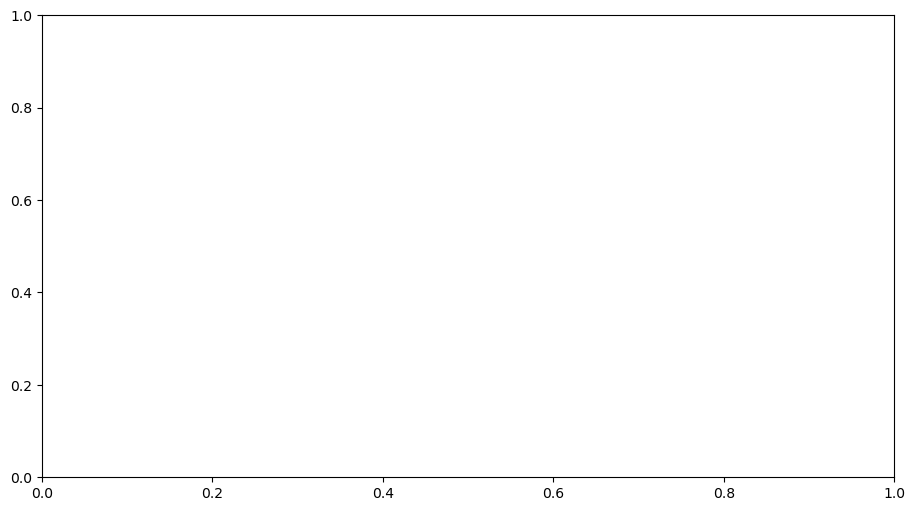

In [18]:
momentums = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999]
rmses = []

for momentum in momentums:
  model = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_features),
  )
  optimizer = optim.SGD(model.parameters(), momentum=momentum, lr=5e-2, nesterov=True)
  criterion = nn.CrossEntropyLoss()
  _, _, rmses_test = train_module(model, optimizer, x_train, y_train, check_rmse , 5, 128, True, x_test, y_test)
  rmse = rmses_test[-1]
  rmses.append(rmse)
  print(f"momentum {momentum} / rmse {rmse}")

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(momentums, rmses, label='momentum')
ax.set_xscale('log')
ax.legend()
ax.set_title("rmses with momentum")
fig.show()

Epoch [1/5] -  Loss: 1.8861 - Rmse: 11.7314
	 	 	  test rmse: 11.5820
Epoch [2/5] -  Loss: 1.4743 - Rmse: 11.3340
	 	 	  test rmse: 11.4987
Epoch [3/5] -  Loss: 2.5201 - Rmse: 10.2823
	 	 	  test rmse: 10.3638
Epoch [4/5] -  Loss: 1.5416 - Rmse: 10.3740
	 	 	  test rmse: 10.6789
Epoch [5/5] -  Loss: 1.7933 - Rmse: 10.4499
	 	 	  test rmse: 10.6239
batch_size 8 / rmse 10.623937606811523
Epoch [1/5] -  Loss: 1.5317 - Rmse: 11.3502
	 	 	  test rmse: 11.3822
Epoch [2/5] -  Loss: 2.1704 - Rmse: 10.5980
	 	 	  test rmse: 10.8553
Epoch [3/5] -  Loss: 1.5291 - Rmse: 10.0971
	 	 	  test rmse: 10.2792
Epoch [4/5] -  Loss: 1.3784 - Rmse: 10.2991
	 	 	  test rmse: 10.5666
Epoch [5/5] -  Loss: 1.9860 - Rmse: 9.6137
	 	 	  test rmse: 9.9450
batch_size 16 / rmse 9.944979667663574
Epoch [1/5] -  Loss: 2.3354 - Rmse: 10.8923
	 	 	  test rmse: 11.0737
Epoch [2/5] -  Loss: 2.2696 - Rmse: 10.6332
	 	 	  test rmse: 10.9132
Epoch [3/5] -  Loss: 1.6749 - Rmse: 9.7291
	 	 	  test rmse: 10.0561
Epoch [4/5] -  

/var/folders/n9/pd4m7bps7_b_427s0yfq1m600000gn/T/ipykernel_46808/115505400.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


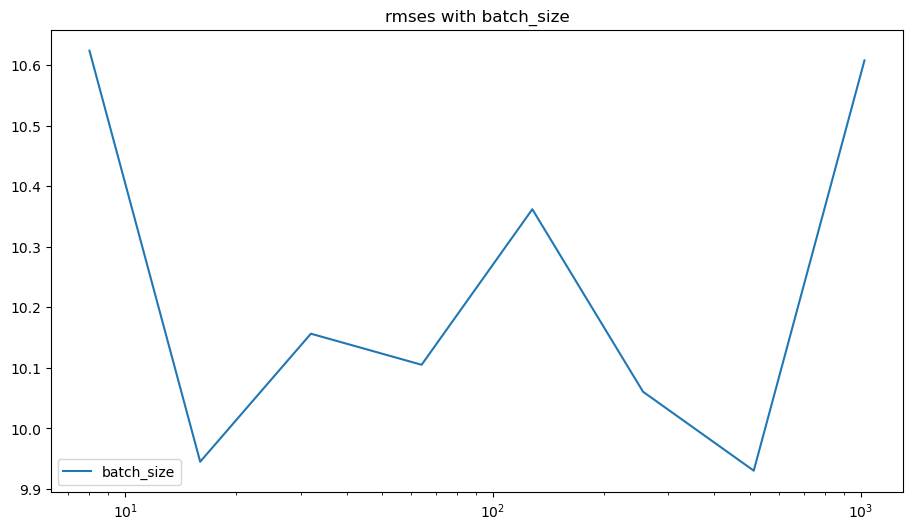

In [20]:
batch_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
rmses = []

for batch_size in batch_sizes:
  model = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_features),
  )
  optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=5e-2, nesterov=True)
  criterion = nn.CrossEntropyLoss()
  _, _, rmses_test = train_module(model, optimizer, x_train, y_train, check_rmse , 5, batch_size, True, x_test, y_test)
  rmse = rmses_test[-1]
  rmses.append(rmse)
  print(f"batch_size {batch_size} / rmse {rmse}")

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(batch_sizes, rmses, label='batch_size')
ax.set_xscale('log')
ax.legend()
ax.set_title("rmses with batch_size")
fig.show()

#VALIDATION

In [13]:
x_val = pd.read_csv('processed_waiting_times_val.csv')
dates = x_val["DATETIME"]
entities = x_val["ENTITY_DESCRIPTION_SHORT"]
x_val.drop(["DATETIME", "ENTITY_DESCRIPTION_SHORT"], axis=1, inplace=True)

x_val = x_val.astype(float)
x_val = torch.tensor(x_val.values, dtype=torch.float64, device=device)
x_val = x_val.to(device=device, dtype=torch.float)

In [14]:
y_hat = torch.argmax(model(x_val), dim=1)

clean_y_hat = np.array((y_hat).cpu())*5

res_df = pd.DataFrame(list(zip(clean_y_hat, entities, dates, ["Validation" for _ in range(len(dates))])), columns=["y_pred", "ENTITY_DESCRIPTION_SHORT", "DATETIME", "KEY"])
#on gdrive
#res_df.to_csv('/content/gdrive/MyDrive/HACKATHON/res.csv', index=False)

#on pc
res_df.to_csv('res.csv', index=False)

autre idée

In [ ]:
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

out_features = 1  # Une seule sortie pour le temps d'attente continu
model = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, out_features),  # Utiliser une seule sortie pour la prédiction continue
)
model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 10

y_train = y_train.float()
y_test = y_test.float()


_ = train_module(model, optimizer, x_train, y_train, check_rmse_numeric ,num_epochs, True, x_test, y_test)

print(check_rmse_numeric(x_test, y_test, model))